# Learning Rate Finder

refs:

1. How reliable: https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it
1. https://fastai1.fast.ai/callbacks.lr_finder.html
1. Good discussion: https://forums.fast.ai/t/new-lr-finder-output/89236/3
1. colab: https://walkwithfastai.com/lr_finder

**GOAL**

* Understand learning rate finder better.
* Why I can choose large values of lr than the lrf reccomendation?
* Is this behavor also on fastai or tensorflow?



Analogy with Gravity (My background is in Physics)

* Potential Energy => Loss Function
* Goal Minimize Potential Energy => Minimize Loss Function 
* Mountain (x,y,z) => Regression Coefficient ($\theta$)
* modify (x,y) to archive the goal => modify $\theta$ to achive the goal
* Bottom of the Bowl or mountain => Minimum Value of Loss (Error)


In [16]:
import numpy as np
import random as rand

import matplotlib
import matplotlib.pyplot as plt
# required for iteractive plot
%matplotlib notebook  

import seaborn as sns
from scipy import stats 

from sklearn.datasets import make_classification, make_blobs, make_regression
from sklearn.metrics import accuracy_score

from typing import List, Dict, Tuple, Callable

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Keras implementation of learning rate finder

https://github.com/WittmannF/LRFinder

In [17]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [65]:
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(512, activation='relu'),
                    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

ValueError: Weights for model sequential_7 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

## Cots functions

### Linera regression

In [18]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y

    return np.matmul(z.T,z)/2.0/n  # <== average of all loss MSE

def gradient_linear_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    
    # error: pred - y
    z = np.matmul(X,theta) - y    
    grad = np.matmul(X.T,z)
        
    return grad/n

### Logistic Regression Sigmoid activation

* vectorized formula of the cost function: https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

* Cost function is also calles **Cross-entropy** or **log loss**

**TODO:** Try to find a demonstartion of the vectorial version of the gradient using matrix derivative

In [19]:
# X: matrix nxd
# y: column vector nx1
# theta: column vector dx1

def cost_func_logistic_regression(theta: np.array, X: np.array, y: np.array) -> np.array:
    
    n = X.shape[0]
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))  # activation: nx1
    
    cost = (-1.0/n)*(np.matmul(y.T,np.log(h)) + np.matmul(1-y.T,np.log(1-h))) # scalar
    
    return cost

def gradient_logistic_regression(theta: np.array, X: np.array, y: np.array)-> np.array:
    
    z = np.matmul(X,theta)
    
    # pred
    h = 1.0/(1.0 + np.exp(-z))  # activation
    
    return np.matmul(X.T,h - y)

## Simulated Data

(50, 2)

(50,)

array([[ 1.        , -1.        ],
       [ 1.        , -0.95918367],
       [ 1.        , -0.91836735]])

True parameters: [4. 5.]
bayes error: 0.01


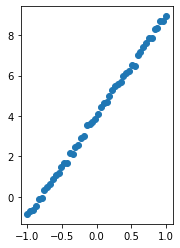

In [20]:
def make_2d_linear_data(slope: float, intercept: float, noise: float, n_sanples: int, random: int = 2021):
    
    x = np.linspace(-1.0, 1.0, n).reshape(n,1)
    
    np.random.seed(random)
    e = np.random.normal(0.0,noise,n).reshape(n,1)
    
    y = slope*x + intercept + e
    y = y.reshape(n,)

    _ones = np.ones((n,1))

    x.shape

    _ones.shape

    X = np.hstack((_ones, x))
    
    return X,y, e

slope = 5.0 
intercept = 4.0
noise = 0.1
n = 50

X,y, e = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

X.shape
y.shape

X[0:3]

print(f"True parameters: {theta_true}")
bayes_error = np.sum(np.matmul(e.T,e))/n  # <== mse
print(f"bayes error: {bayes_error:.2f}")

_ = plt.subplot(121);
_ = plt.scatter(X[:,1],y);

plt.show()

## TUNING Learning rate 

https://miguel-data-sc.github.io/2017-11-05-first/
https://arxiv.org/abs/1506.01186

1. learning rate finding 
1. learnig rate find vs batchs size

Needs to introduce learning rate shdedule $\eta = \eta(t)$ in mini batch algo

In [21]:
from abc import ABC, abstractmethod

class LearningRateScheduler(ABC):

    def __init__(self, lr0: float ):
        
        self._lr0 = lr0
        
    @abstractmethod
    def run(it: int) -> float: 
        return
    
class ConstLearningRateScheduler(LearningRateScheduler):
    
    def run(self, it: int) -> float: 
        return self._lr0
    
class FindLearningRateScheduler(LearningRateScheduler):
    
    def __init__(self, lr0: float, number_of_lr_per_order: int = 4 ):
    
        super().__init__(lr0)
        
        self._lr0 = lr0
        self._number_of_lr_per_order = number_of_lr_per_order
    
    def run(self, it: int) -> float: 
        
        lr = self._lr0*(10**(it/self._number_of_lr_per_order))
        
        return lr

In [22]:
lr_scheduler = ConstLearningRateScheduler(0.01)

lr_scheduler.run(10)
lr_scheduler.run(100)

0.01

0.01

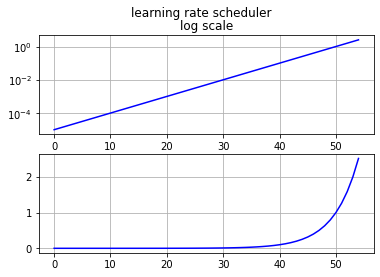

In [23]:
n_iter = 55

lr_scheduler = FindLearningRateScheduler(1e-5,number_of_lr_per_order=10)

lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)

fig, (ax1, ax2) = plt.subplots(2);
fig.suptitle('learning rate scheduler');
ax1.plot(range(n_iter),lrs,'b',label='');
ax1.set_yscale('log');
ax1.grid(True);
ax1.set_title('log scale');
ax2.plot(range(n_iter),lrs,'b',label='learning rate scheduler');
ax2.grid(True);

In [24]:
def create_mini_batches(data_shuffle, batch_size):
    
    n = data_shuffle.shape[0]
    mini_batches = []
    
    for k in np.arange(0, n, batch_size):
        
        X_mini = data_shuffle[k:k+batch_size,:-1]
        y_mini = data_shuffle[k:k+batch_size,-1]
        
        mini_batches.append((X_mini,y_mini))
    return mini_batches

def mini_batch_gradient_descent(X,y, cost_func, gradient_func, 
                                learning_rate_scheduler: Callable[[float,int], float],
                                n_iterations: int,
                                batch_size: int, 
                                init_guess: np.array,seed: int =1):
    
    n = X.shape[0] # training size
    d = X.shape[1]  # number of dimensions or paramters
    
    theta = init_guess

    Xy = np.hstack((X,y.reshape((n,1))))
        
    theta_history = []
    grad_history = []
    cost_history = []
 
    np.random.seed(seed)
    for it in range(0,n_iterations):
           
        data_shuffle = Xy.copy()
        np.random.shuffle(data_shuffle)
        
        cost = 0.0
        mini_batches = create_mini_batches(data_shuffle,batch_size)
        
        for X_mini, y_mini in mini_batches:

            # compute the gradients and cost function
            cost += cost_func(theta,X_mini,y_mini)
            gradient_at_theta = gradient_func(theta,X_mini,y_mini)  # gradient approximation using 1 data point
            

            # log history for oploting
            theta_history.append(theta.T)
            grad_history.append(gradient_at_theta)
            
           # update parameters
            learning_rate = learning_rate_scheduler.run(it)
            dtheta = -learning_rate* gradient_at_theta

            theta = theta + dtheta
            
        cost_history.append(cost/len(mini_batches)) # << average loss in the epoch 

    history = {'theta': theta_history, "cost": cost_history, "grad": grad_history}

    return theta, history

### Test on regression

True parameters: [4. 5.]
bayes error: 0.00


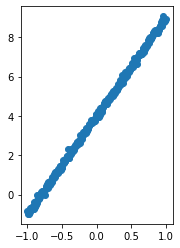

In [54]:
slope = 5.0 
intercept = 4.0
noise = 0.1
n = 300

X,y,_ = make_2d_linear_data(slope,intercept, noise, n)
theta_true = np.array([intercept,slope])

print(f"True parameters: {theta_true}")
bayes_error = np.sum(np.matmul(e.T,e))/n  # <== mse
print(f"bayes error: {bayes_error:.2f}")

_ = plt.subplot(121);
_ = plt.scatter(X[:,1],y);

plt.show()

In [55]:
n_iter = 53
bs = 18

lr_scheduler = FindLearningRateScheduler(1e-6,number_of_lr_per_order=8)

init_guess = np.array([1.0,0.5])


theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)



theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")

print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [-3.28561325 -1.42030567]; cost: 7.92
it: 52 => theta: [ 4168772.67048917 -1520076.24921454]; grad: [4211981.68570158 -669615.61790329]; cost: 682277336773.12



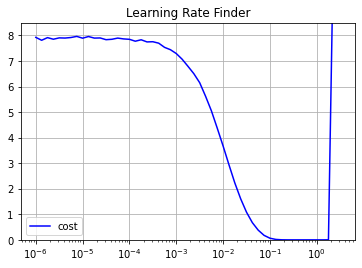

In [56]:
lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)

cost = history['cost'] 

plt.subplots()
plt.plot(lrs,cost,'b',label='cost');
plt.xscale('log');
plt.ylim(0.0,8.5);
plt.legend();
plt.title('Learning Rate Finder');
plt.grid(True);

In [57]:
X.shape
y.shape

(300, 2)

(300,)

In [58]:

W01 = tf.constant_initializer(0.5)
b01 = tf.constant_initializer(1.0)

model = tf.keras.Sequential([
                tf.keras.layers.Dense(1, activation='relu',
                          kernel_initializer=W01,
                          bias_initializer=b01,
                          input_shape=(2,))
    ])

sgd = tf.keras.optimizers.SGD(learning_rate=lr, 
                              momentum=0.0,
                              nesterov=False, name='SGD'
                             )


model.compile(loss='mse', optimizer=sgd, metrics=['mse'])

_ = model.fit(X, y, epochs=n_iter, batch_size=bs, verbose=0, validation_split=0.0)

Epoch 1/2
17/17 [==============================] - 0s 3ms/step - loss: 0.0437 - mse: 0.0437
Epoch 2/2
17/17 [==============================] - 0s 3ms/step - loss: 0.0437 - mse: 0.0437


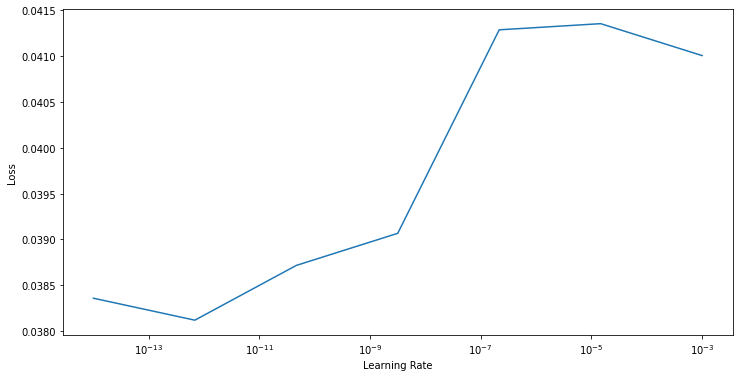

In [61]:
# 3. Fit using Callback
lr_finder = LRFinder(min_lr=1e-14, max_lr=0.001)


model.fit(X, y, batch_size=bs, callbacks=[lr_finder], epochs=2)

### testing logistic regression

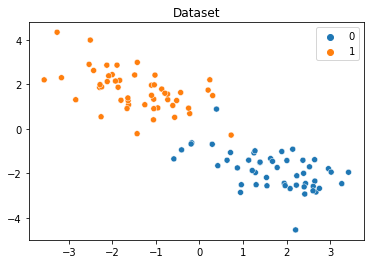

In [25]:
# other options are also available
X, y = make_classification(
    n_samples=100, 
    n_classes=2,
    n_clusters_per_class=1,
    n_features=2,
    n_redundant = 0,
    n_informative = 2,
    n_repeated = 0,
    weights=[0.5,0.5], # balanced classes
    flip_y=0.001, # add noisy the default value for flip_y is 0.1%
    class_sep=1.7, # class_sep is 1.0. The lower the value, the harder classification is.
    random_state=2020) 

ax = sns.scatterplot(X[:,0],X[:,1],hue=y);
ax.set_title("Dataset");

In [26]:
lr = 0.1
n_iter = 200
bs = 100

lr_scheduler = ConstLearningRateScheduler(lr)

init_guess = np.array([1.0,0.5])

theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")
print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 199 => theta: [-0.02352229  0.19788771]; grad: [7.42818314e-05 6.78048566e-05]; cost: 0.16
Expected theta:[4. 5.]



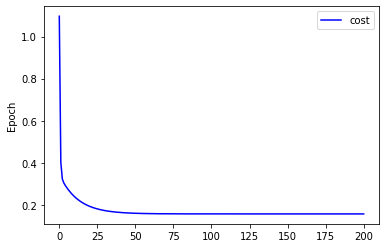

In [27]:
cost = history['cost']
    
    
m = len(cost)
x = np.linspace(0,n_iter,m)
    
fig,ax = plt.subplots()
_ = ax.plot(x,cost,'b',label='cost');
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();

In [28]:
n_iter = 54
bs = 100

lr_scheduler = FindLearningRateScheduler(1e-5,number_of_lr_per_order=10)

init_guess = np.array([1.0,0.5])

theta, history = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


theta0 = history['theta'][0]
grad0 =  history['grad'][0]
cost0 = history['cost'][0]

print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

it = n_iter -1
theta = history['theta'][-1]
grad =  history['grad'][-1]
cost = history['cost'][-1]

print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
print(f"Expected theta:{theta_true}")
print()

Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 53 => theta: [-0.45956011  0.70088545]; grad: [-3.09255999  3.3984169 ]; cost: 1.69
Expected theta:[4. 5.]



first 5 lrs: [1.00000000e-05 1.25892541e-05 1.58489319e-05 1.99526231e-05
 2.51188643e-05]
last 5 lrs: [0.79432823 1.         1.25892541 1.58489319 1.99526231]
last 5 cost: [0.16923198299949824, 0.16242434361657435, 0.15894349939111027, 0.17260044259144208, 1.6855897378334077]


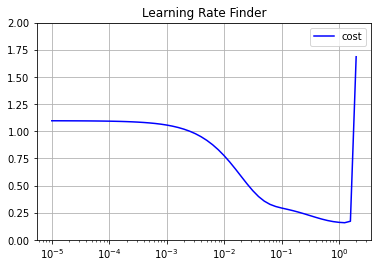

In [29]:
lrs = np.zeros((n_iter,))
for it in range(n_iter):
    
    lrs[it] = lr_scheduler.run(it)


cost = history['cost'] 
print(f"first 5 lrs: {lrs[0:5]}")
print(f"last 5 lrs: {lrs[-5:]}")
print(f"last 5 cost: {cost[-5:]}")


plt.subplots()
plt.plot(lrs,cost,'b',label='cost');
plt.xscale('log');
plt.ylim(0.0,2.0);
plt.legend();
plt.title('Learning Rate Finder');
plt.grid(True);

In [30]:
lrs[-13:]
cost[-13:]

array([0.12589254, 0.15848932, 0.19952623, 0.25118864, 0.31622777,
       0.39810717, 0.50118723, 0.63095734, 0.79432823, 1.        ,
       1.25892541, 1.58489319, 1.99526231])

[0.28236320118290964,
 0.2697214026137461,
 0.25561080866901187,
 0.2401994031235337,
 0.22399862304949295,
 0.2077872792168337,
 0.19256709907139824,
 0.1794165159651306,
 0.16923198299949824,
 0.16242434361657435,
 0.15894349939111027,
 0.17260044259144208,
 1.6855897378334077]

In [228]:
sim = [('manual', 0.01),
       ('tuned lr',0.2 )]

n_iter = 300
init_guess
bs

for name, lr in sim:

    lr_scheduler = ConstLearningRateScheduler(lr)
    
    theta, history[name] = mini_batch_gradient_descent(X, y, cost_func_linear_regression, gradient_linear_regression, 
                                             lr_scheduler, n_iter,bs, init_guess)


    print(f"{name}, lr: {lr}")
    theta0 = history[name]['theta'][0]
    grad0 =  history[name]['grad'][0]
    cost0 = history[name]['cost'][0]

    print(f"Initial Guess it: 0 => theta: {theta0}; grad: {grad0}; cost: {cost0:.2f}")

    it = n_iter -1
    theta = history[name]['theta'][-1]
    grad =  history[name]['grad'][-1]
    cost = history[name]['cost'][-1]

    print(f"it: {it} => theta: {theta}; grad: {grad}; cost: {cost:.2f}")
    
    z = np.matmul(X,theta)  # nx1
    h = 1.0/(1.0 + np.exp(-z))
    y_pred = h > 0.5

    acc = accuracy_score(y, y_pred)
    print(f"accuracy: {acc}")
    
    #print(f"Expected theta:{theta_true}")
    print()


array([1. , 0.5])

100

manual, lr: 0.01
Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 299 => theta: [0.18585499 0.38900841]; grad: [0.08524474 0.07781186]; cost: 0.17
accuracy: 0.94

tuned lr, lr: 0.2
Initial Guess it: 0 => theta: [1.  0.5]; grad: [ 2.46180965 -2.11780916]; cost: 1.10
it: 299 => theta: [-0.0237049   0.19772102]; grad: [2.76047074e-12 2.51986709e-12]; cost: 0.16
accuracy: 0.97



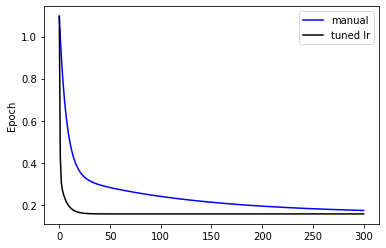

In [229]:
colors = ['b','k','g']

fig,ax = plt.subplots()
for idx, hyper_params in enumerate(sim):
    
    name, lr = hyper_params= hyper_params
    
    cost = history[name]['cost']
    
    m = len(cost)
    x = np.linspace(0,n_iter,m)
    
    _ = ax.plot(x,cost,colors[idx],label=name);
    
#_ = ax.set_ylim([6, 8])
_ = ax.set_ylabel("Cost")
_ = ax.set_ylabel("Epoch")
ax.legend();